In [1]:
library(repr)
options(repr.plot.width=4, repr.plot.height=4)

### Raup Crick Distance via Bray Curtis: 
#### Resamples OTUs into a community to match observed richness, based on site occupancy distribution across the full data set and calculates bray curtis distance. The value is the proportion of runs where the distance is less than expected, scaled between -1,1. 

### Mean nearest taxon distance (MNTD): 
#### The mean distance between each species in community A and its closest relative in community B across 999 resampling trials
#### Called Nearest Taxon Index (MNTI), when standardized (i.e. z-value) 


In [2]:
row_reference = "../otu_data/WaterQualityData/matched_cleaned_data/all_mdata_colset_2.tsv"
included_samples <- read.delim(row_reference, row.names=1)
incl_samps = rownames(included_samples)
stoch_df <-data.frame(matrix(nrow=sum((dim(included_samples)[1]-1):1), ncol=5))
names(stoch_df)<-c("Com1", "Com2", 'BNTI', 'RC', 'Outcome')
print(dim(stoch_df))

row_counter=0
for (i in 1:length(incl_samps)){
    for (j in i:length(incl_samps)){
        if (i != j ){
            row_counter = row_counter + 1
            stoch_df[row_counter, 'Com1'] <- incl_samps[i]
            stoch_df[row_counter, 'Com2'] <- incl_samps[j]
        }
    }
}

print(row_counter)
print(head(stoch_df))

[1] 41905     5
[1] 41905
                           Com1                          Com2 BNTI RC Outcome
1 SB072215TAWCSCB33CD0BR1TR1I27 SB072215TAWCSCB33CD2BR1TR1I29   NA NA      NA
2 SB072215TAWCSCB33CD0BR1TR1I27 SB072215TAWCSCB33CD3BR1TR1I30   NA NA      NA
3 SB072215TAWCSCB33CD0BR1TR1I27 SB072215TAWCSCB33CD4BR1TR1I31   NA NA      NA
4 SB072215TAWCSCB33CD0BR1TR1I27 SB072215TAWCSCB33CD6BR1TR1I33   NA NA      NA
5 SB072215TAWCSCB33CD0BR1TR1I27 SB072215TAWCSCB33CD7BR1TR1I34   NA NA      NA
6 SB072215TAWCSCB33CD0BR1TR1I27 SB072215TAWCSCB33CD9BR1TR1I36   NA NA      NA


[1] 0


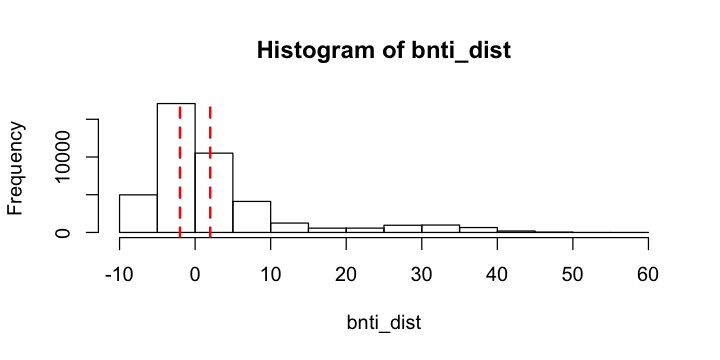

In [3]:
nti_fn = "../otu_data/dispersal_selection_data/ses_nti.RData"
load(nti_fn)
bnti_df = mntd_scores$comdistnt.obs.z[incl_samps, incl_samps]
bnti_dist = as.dist(bnti_df)

options(repr.plot.width=6, repr.plot.height=3)
h <- hist(bnti_dist)
abline(v = 2, col="red", lwd=2, lty=2)
abline(v = -2, col="red", lwd=2, lty=2)

for (row in 1:dim(stoch_df)[1]){
    stoch_df[row, 'BNTI'] = bnti_df[stoch_df[row, 'Com1'], stoch_df[row, 'Com2']]
}

print(sum(is.na(stoch_df[,'BNTI'])))

[1] 8
[1] 0


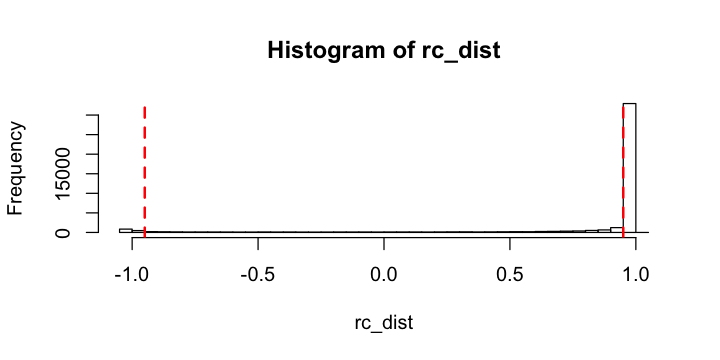

In [4]:
rc_fn = "../otu_data/dispersal_selection_data/raup_crick_data.tsv"
rc_df <- read.delim(rc_fn, row.names=1)[rownames(included_samples), rownames(included_samples)]
rc_df2 = rc_df
rc_df2[is.na(rc_df2)] <- 0

rc_dft = t(rc_df)
rc_dft2 = rc_dft
rc_dft2[is.na(rc_dft2)] <- 0

rc_sym = as.matrix(rc_df2 + rc_dft2)
for (i in 1:dim(rc_df)[1]){ 
    rc_sym[i,i] <- rc_df[i,i]
}

rc_dist = as.dist(rc_sym)
print(sum(rc_dist > 1))
rc_dist[rc_dist > 1] <- 1

options(repr.plot.width=6, repr.plot.height=3)
h <- hist(rc_dist, breaks=-1:41/20 - 1)
abline(v = 0.95, col="red", lwd=2, lty=2)
abline(v = -0.95, col="red", lwd=2, lty=2)

for (row in 1:dim(stoch_df)[1]){
    stoch_df[row, 'RC'] = rc_sym[stoch_df[row, 'Com1'], stoch_df[row, 'Com2']]
}

print(sum(is.na(stoch_df[,'RC'])))

Selection can act in two opposite directions, 
homogeneous selection: constraining selection such that only similar organisms are selected for
heterogeneous selection: a divergent community is selected for.


In [5]:
print(c('Number of pairwise comparisons:', dim(stoch_df)[1]))
print(c(""))
print(c('Deterministic via phylogeny:', round(sum(abs(stoch_df$BNTI) > 2)/dim(stoch_df)[1],3)*100 ))
print(c('-> Undergoing hetero. selection:', round(sum(stoch_df$BNTI > 2)/dim(stoch_df)[1],3)*100 ))

heter_disp = (stoch_df$BNTI > 2) & (stoch_df$RC > 0.95)
print(c('--> Heterog. dispersal:', round(sum(heter_disp)/dim(stoch_df)[1],3)*100 ))

print(c('-> Undergoing homo. selection:', round(sum(stoch_df$BNTI < -2)/dim(stoch_df)[1],3)*100 ))

homo_disp = (stoch_df$BNTI < -2) & (stoch_df$RC > 0.95)
print(c('--> Homog. dispersal:', round(sum(homo_disp)/dim(stoch_df)[1],3)*100 ))

print(c(""))
stoch_frac = (abs(stoch_df$BNTI) < 2)
print(c('Stochastic via phylogeny:', round(sum(stoch_frac)/dim(stoch_df)[1],3)*100 ))

disp_frac = (abs(stoch_df$BNTI) < 2) & (abs(stoch_df$RC) > 0.95)
print(c('-> Influenced by dispersal:', round(sum(disp_frac)/dim(stoch_df)[1],3)*100 ))

homo_frac = (abs(stoch_df$BNTI) < 2) & (stoch_df$RC < -0.95)
print(c('--> High dispersal:', round(sum(homo_frac)/dim(stoch_df)[1],3)*100 ))

ltd_frac = (abs(stoch_df$BNTI) < 2) & (stoch_df$RC > 0.95)
print(c('--> Low dispersal:', round(sum(ltd_frac)/dim(stoch_df)[1],3)*100 ))

und_frac = (abs(stoch_df$BNTI) < 2) & (abs(stoch_df$RC) < 0.95)
print(c('-> Undominated:', round(sum(und_frac)/dim(stoch_df)[1],3)*100 ))



[1] "Number of pairwise comparisons:" "41905"                          
[1] ""
[1] "Deterministic via phylogeny:" "70.5"                        
[1] "-> Undergoing hetero. selection:" "34.5"                            
[1] "--> Heterog. dispersal:" "33.3"                   
[1] "-> Undergoing homo. selection:" "36.1"                          
[1] "--> Homog. dispersal:" "18.3"                 
[1] ""
[1] "Stochastic via phylogeny:" "29.5"                     
[1] "-> Influenced by dispersal:" "27"                         
[1] "--> High dispersal:" "0"                  
[1] "--> Low dispersal:" "27"                
[1] "-> Undominated:" "2.2"            


In [9]:
#Probe & USGS Discharge Data
env_data_file = "/Volumes/KeithSSD/CB_V4/otu_data/WaterQualityData/matched_cleaned_data/all_mdata_with_habitat.txt"
env_data <- read.delim(env_data_file, row.names=1)

env_data$Year <- factor(env_data$Year)
env_data$Month <- factor(env_data$Month)
env_data$habitat <- factor(env_data$habitat)

# Chesapeake Bay Foundation Data 
transect_data_f = "../otu_data/WaterQualityData/matched_cleaned_data/transect_mdata_colset_1.tsv"
tran_df <- read.delim(transect_data_f, row.names=1)
missing_columns = setdiff(colnames(tran_df), colnames(env_data))

for (i in missing_columns){
    env_data[,i] <- NA
    env_data[rownames(tran_df),i] = tran_df[rownames(tran_df), i]
}

# SalZone
env_data[,'SalZone'] <- NA
oligohaline <- c('CB22', 'CB31')
mesohaline <- c('CB32', 'CB33C', 'CB41C', 'CB42C', 'CB43C', 'CB44', 'CB51', 'CB52', 'CB53', 'CB54')
polyhaline <- c('CB61', 'CB62', 'CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74')
env_data[which(env_data[,'StationName'] %in% oligohaline),'SalZone'] <- '1_oligohaline'
env_data[which(env_data[,'StationName'] %in% mesohaline),'SalZone'] <- '2_mesohaline'
env_data[which(env_data[,'StationName'] %in% polyhaline),'SalZone'] <- '3_polyhaline'
env_data$SalZone <- factor(env_data$SalZone)
table(env_data$SalZone)

# Depth_segment
env_data[,'depth_segment'] <- NA
env_data[which(env_data[,'StationName'] != 'CB33C' & env_data$depth_float > 2), 'depth_segment'] = 'Bottom'
env_data[which(env_data$depth_float < 2), 'depth_segment'] = 'Top'
env_data[which(env_data[,'StationName'] == 'CB33C' & env_data$depth_float > 17), 'depth_segment'] = 'Bottom'
env_data[is.na(env_data$depth_segment), 'depth_segment'] <- 'Middle'
env_data[,'depth_segment'] = factor(env_data[,'depth_segment'], levels=c('Top', 'Middle', 'Bottom'))
table(env_data[,c("StationName", 'depth_segment')])

# StatName
env_data[,'StatName'] <- NA
statg1 <- c('CB22', 'CB31', 'CB32')
statg2 <- c('CB33C')
statg3 <- c('CB41C', 'CB42C', 'CB43C', 'CB44')
statg4 <- c('CB51', 'CB52', 'CB53', 'CB54')
statg5 <- c('CB61', 'CB62', 'CB63', 'CB64')
statg6 <- c('CB71', 'CB72', 'CB73', 'CB74')

env_data[which(env_data[,'StationName'] %in% statg1),'StatName'] <- '1'
env_data[which(env_data[,'StationName'] %in% statg2),'StatName'] <- '2'
env_data[which(env_data[,'StationName'] %in% statg3),'StatName'] <- '3'
env_data[which(env_data[,'StationName'] %in% statg4),'StatName'] <- '4'
env_data[which(env_data[,'StationName'] %in% statg5),'StatName'] <- '5'
env_data[which(env_data[,'StationName'] %in% statg6),'StatName'] <- '6'

env_data$StatName <- factor(env_data$StatName)
table(env_data$StatName)


1_oligohaline  2_mesohaline  3_polyhaline 
           18           185            87 

           depth_segment
StationName Top Middle Bottom
      CB22    0      0      9
      CB31    0      0      9
      CB32    0      0      7
      CB33C  14     67     20
      CB41C   0      0      2
      CB42C   0      0      8
      CB43C   0      0     11
      CB44    5      0     10
      CB51    0      0      9
      CB52    0      0      2
      CB53    6      0      8
      CB54    7      0      9
      CB61    4      0      6
      CB62    7      0      9
      CB63    7      0      9
      CB64    0      0      3
      CB71    6      0      9
      CB72    5      0      7
      CB73    6      0      7
      CB74    0      0      2


  1   2   3   4   5   6 
 25 101  36  41  45  42 

In [30]:
select_cols = c('StatName', 'Year', 'Month', 'Discharge_Susquehanna_14', 'Latitude', 'Longitude',
                'depth_segment', 'habitat', 'enspie', 'faith_pd', 'day_length', 'CollectionAgency', 
                'anti_day_length', 'WTEMP', 'SALINITY', 'DO', 'DOP', 'NO2F', 'PC', 'PHEO', 'NO3F', 
                'NH4F', 'TP', 'CHLA', 'TDN', 'SalZone', 'AC_PrinComp1', 'AC_PrinComp2', 'depth_float', 
                'TrimCount', 'Month_Year')
ENV.maxi = env_data[,select_cols]
str(ENV.maxi)

'data.frame':	290 obs. of  31 variables:
 $ StatName                : Factor w/ 6 levels "1","2","3","4",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Year                    : Factor w/ 3 levels "15","16","17": 1 1 1 1 1 1 1 1 1 1 ...
 $ Month                   : Factor w/ 6 levels "4","5","6","7",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Discharge_Susquehanna_14: num  643639 643639 643639 643639 643639 ...
 $ Latitude                : num  39 39 39 39 39 ...
 $ Longitude               : num  -76.4 -76.4 -76.4 -76.4 -76.4 ...
 $ depth_segment           : Factor w/ 3 levels "Top","Middle",..: 1 2 2 2 2 2 2 2 2 2 ...
 $ habitat                 : Factor w/ 3 levels "1","2","3": 3 3 3 3 1 1 2 2 2 2 ...
 $ enspie                  : num  32 52.5 48.4 53.3 38.9 ...
 $ faith_pd                : num  14.3 33.4 32.6 33.8 11.3 ...
 $ day_length              : num  0.857 0.857 0.857 0.857 0.857 ...
 $ CollectionAgency        : Factor w/ 3 levels "DNR","ODU","Preheim": 3 3 3 3 3 3 3 3 3 3 ...
 $ anti_day_length         : n

In [31]:
library(phyloseq)

# read the OTU table, subset by samples we desire
OTU = read.delim("../otu_data/final_rarefied_table.tsv", row.names=1)
OTU.clean1 = OTU[rownames(env_data), ]
# filter OTUs only found in controls or other peoples samples and convert to matrix
OTU.clean = as.matrix(OTU.clean1[,colSums(OTU.clean1) > 0])

# read Taxonomy of each OTU, convert to matrix, replace emtpy strings with Nulls and subset to match
tax = read.delim("../otu_data/dada2_outputs/taxa_table_with_OTUs.txt", row.names=1)
tax_mat = as.matrix(tax)
colnames(tax_mat)[1] <- 'Domain'
tax_mat[tax_mat == ""] <- NA
tax.clean = tax_mat[colnames(OTU.clean), ]

# read tree, prune absent taxa, 
tree_file = "../otu_data/tree_data/not_full_tree/RAxML_rootedTree.root.query_high_abund.ref.tre"
tree_obj = read_tree(tree_file, errorIfNULL=T)
tree.clean = prune_taxa(taxa=colnames(OTU.clean), tree_obj)

# create phyloseq objects
OTU.phylo = otu_table(OTU.clean, taxa_are_rows = FALSE)
TAX.phylo = tax_table(tax.clean)
physeq2 = phyloseq(OTU.phylo, TAX.phylo, ENV.maxi, tree.clean)

physeq2

bc_dist = phyloseq::distance(physeq2, method="bray", weighted=F)
wunf_dist = phyloseq::distance(physeq2, method="unifrac", weighted=T)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1558 taxa and 290 samples ]
tax_table()   Taxonomy Table:    [ 1558 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1558 tips and 1557 internal nodes ]

In [128]:
# inputs are booleans, names, 
heterosel_pairs = stoch_df$BNTI > 2
homosel_pairs = stoch_df$BNTI < -2
dispLimit_pairs = (abs(stoch_df$BNTI) <= 2) & (stoch_df$RC > 0.95)
dispHigh_pairs = (abs(stoch_df$BNTI) <= 2) & (stoch_df$RC < -0.95)
unDom_pairs = (abs(stoch_df$BNTI) < 2) & (abs(stoch_df$RC) <= 0.95)
n_categorized_forces = sum(heterosel_pairs) + sum(homosel_pairs) + sum(dispHigh_pairs) +
                       sum(dispLimit_pairs) + sum(unDom_pairs)
n_categorized_forces == dim(stoch_df)[1]

cat_cols = c("StatName", 'Month', 'Year', 'depth_segment', 'habitat')
dist_cols = c("BC", "UF")
num_cols = c('SALINITY', 'julian_day', 'faith_pd', 'Latitude', 'AC_PrinComp1', 'AC_PrinComp2',
             'anti_day_length')
n_metadata = length(cat_cols) + length(dist_cols) + length(num_cols)

env_by_dists = data.frame(matrix(nrow=n_categorized_forces, ncol=n_metadata))
rownames(env_by_dists) <- rownames(stoch_df)
colnames(env_by_dists) <- c(cat_cols, num_cols, dist_cols)
full_df = cbind.data.frame(stoch_df, env_by_dists)
full_df[heterosel_pairs, 'Outcome'] = 'HeterSel'
full_df[homosel_pairs, 'Outcome'] = 'HomoSel'
full_df[dispLimit_pairs, 'Outcome'] = 'LtdDisp'
full_df[dispHigh_pairs, 'Outcome'] = 'HighDisp'
full_df[unDom_pairs, 'Outcome'] = 'Undom'
table(full_df[,'Outcome'])

[1] TRUE


HeterSel HighDisp  HomoSel  LtdDisp    Undom 
   14456        6    15107    11317     1019 

In [135]:
for (cat_i in cat_cols){
    cat_vect = as.character(env_data[, cat_i])
    names(cat_vect) <- rownames(env_data)
    cat_possib = unique(cat_vect)
    cat_possib_pairs = outer(cat_possib, cat_possib, paste, sep=".")
    cat_possib_pairs = base::sort(cat_possib_pairs[!lower.tri(cat_possib_pairs)])
     message(cat_i, " ", length(cat_possib_pairs))
     message(paste(cat_possib_pairs, collapse=" "))
    for (row_i in 1:nrow(full_df)){
        pwc1 = full_df[row_i, 'Com1']; pwc2 = full_df[row_i, 'Com2'];
        pwc_double = c(cat_vect[pwc1], cat_vect[pwc2])
        vec_pair = base::sort(pwc_double)
        str_pair = paste(vec_pair, collapse=".")
        full_df[row_i, cat_i] = str_pair
    }
}

StatName 21
1.1 1.3 1.4 1.5 1.6 2.1 2.2 2.3 2.4 2.5 2.6 3.3 3.4 3.5 3.6 4.4 4.5 4.6 5.5 6.5 6.6
Month 21
4.4 4.5 4.9 5.5 5.9 6.4 6.5 6.6 6.9 7.4 7.5 7.6 7.7 7.8 7.9 8.4 8.5 8.6 8.8 8.9 9.9
Year 6
15.15 15.16 15.17 16.16 16.17 17.17
depth_segment 6
Bottom.Bottom Middle.Bottom Middle.Middle Top.Bottom Top.Middle Top.Top
habitat 6
1.1 1.2 2.2 3.1 3.2 3.3


In [129]:
for (num_i in num_cols){
    message(num_i)
    for (row_i in 1:nrow(full_df)){
        pwc1 = full_df[row_i, 'Com1']; pwc2 = full_df[row_i, 'Com2'];
        if (sum(is.na(env_data[c(pwc1, pwc2), num_i])) > 0) {
            full_df[row_i, num_i] <- NA
        } else {
            full_df[row_i, num_i] = abs(env_data[pwc1, num_i] - env_data[pwc2, num_i])
        }
    }
    message(sum(is.na(full_df[,num_i]))/nrow(full_df))
}

SALINITY
0
julian_day
0
faith_pd
0
Latitude
0
AC_PrinComp1
0
AC_PrinComp2
0
anti_day_length
0


In [131]:
bc_dist_mat = as.matrix(bc_dist)
wunf_dist_mat = as.matrix(wunf_dist)

for (row_i in 1:nrow(full_df)){
    pwc1 = full_df[row_i, 'Com1']; pwc2 = full_df[row_i, 'Com2'];
    full_df[row_i, 'BC'] = bc_dist_mat[pwc1, pwc2]
    full_df[row_i, 'UF'] = wunf_dist_mat[pwc1, pwc2]
}
aggregate(x=full_df[,dist_cols], by=list(full_df[,'Outcome']), FUN=function(x){median(x, na.rm=T)})

Group.1,BC,UF
<chr>,<dbl>,<dbl>
HeterSel,0.8850383,0.5306856
HighDisp,0.5643119,0.2754548
HomoSel,0.6161280,0.3253557
LtdDisp,0.7797401,0.4170735
Undom,0.6701100,0.3587150


In [153]:
library(nnet)
selected_preds = c('SALINITY', 'julian_day', 'faith_pd', 'Latitude', 'AC_PrinComp1', 'AC_PrinComp2',
                   'depth_segment', 'anti_day_length')
reg_df = full_df[,c('Outcome', selected_preds)]
reg_df2 = reg_df[which(reg_df$Outcome != 'HighDisp'), ]

reg_df2$Outcome <- factor(reg_df2$Outcome, levels=c("HeterSel", "Undom", 'LtdDisp', "HomoSel"), ordered=F)
reg_df2$depth_segment <- factor(reg_df2$depth_segment, ordered=F)

str(reg_df2)
dim(reg_df)

'data.frame':	41899 obs. of  9 variables:
 $ Outcome        : Factor w/ 4 levels "HeterSel","Undom",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ SALINITY       : num  1.1 1.86 1.81 5.24 8.85 ...
 $ julian_day     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ faith_pd       : num  19.18 18.356 19.575 2.954 0.513 ...
 $ Latitude       : num  0.000015 0.000064 0.000167 0.000232 0.000297 ...
 $ AC_PrinComp1   : num  0.547 0.955 0.731 2.862 4.681 ...
 $ AC_PrinComp2   : num  0.0479 0.08 0.05 0.3479 0.7133 ...
 $ depth_segment  : Factor w/ 6 levels "Bottom.Bottom",..: 5 5 5 5 5 5 5 5 5 3 ...
 $ anti_day_length: num  0 0 0 0 0 0 0 0 0 0 ...


[1] 41905     9

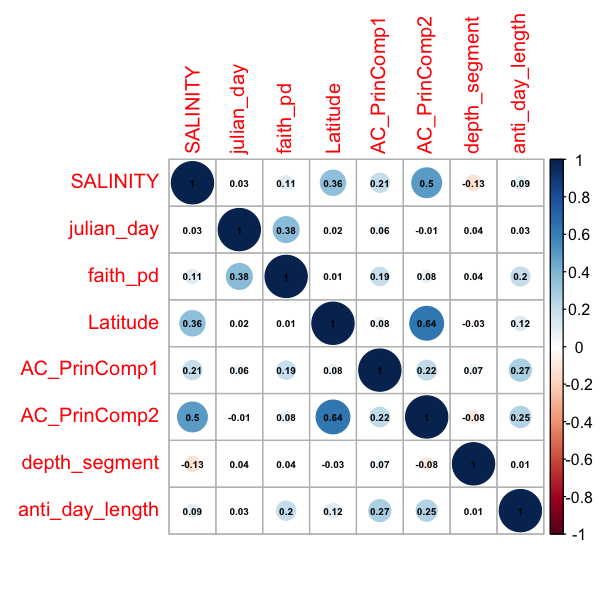

[1] "Bottom.Bottom" "Bottom.Middle" "Bottom.Top"    "Middle.Middle"
[5] "Middle.Top"    "Top.Top"

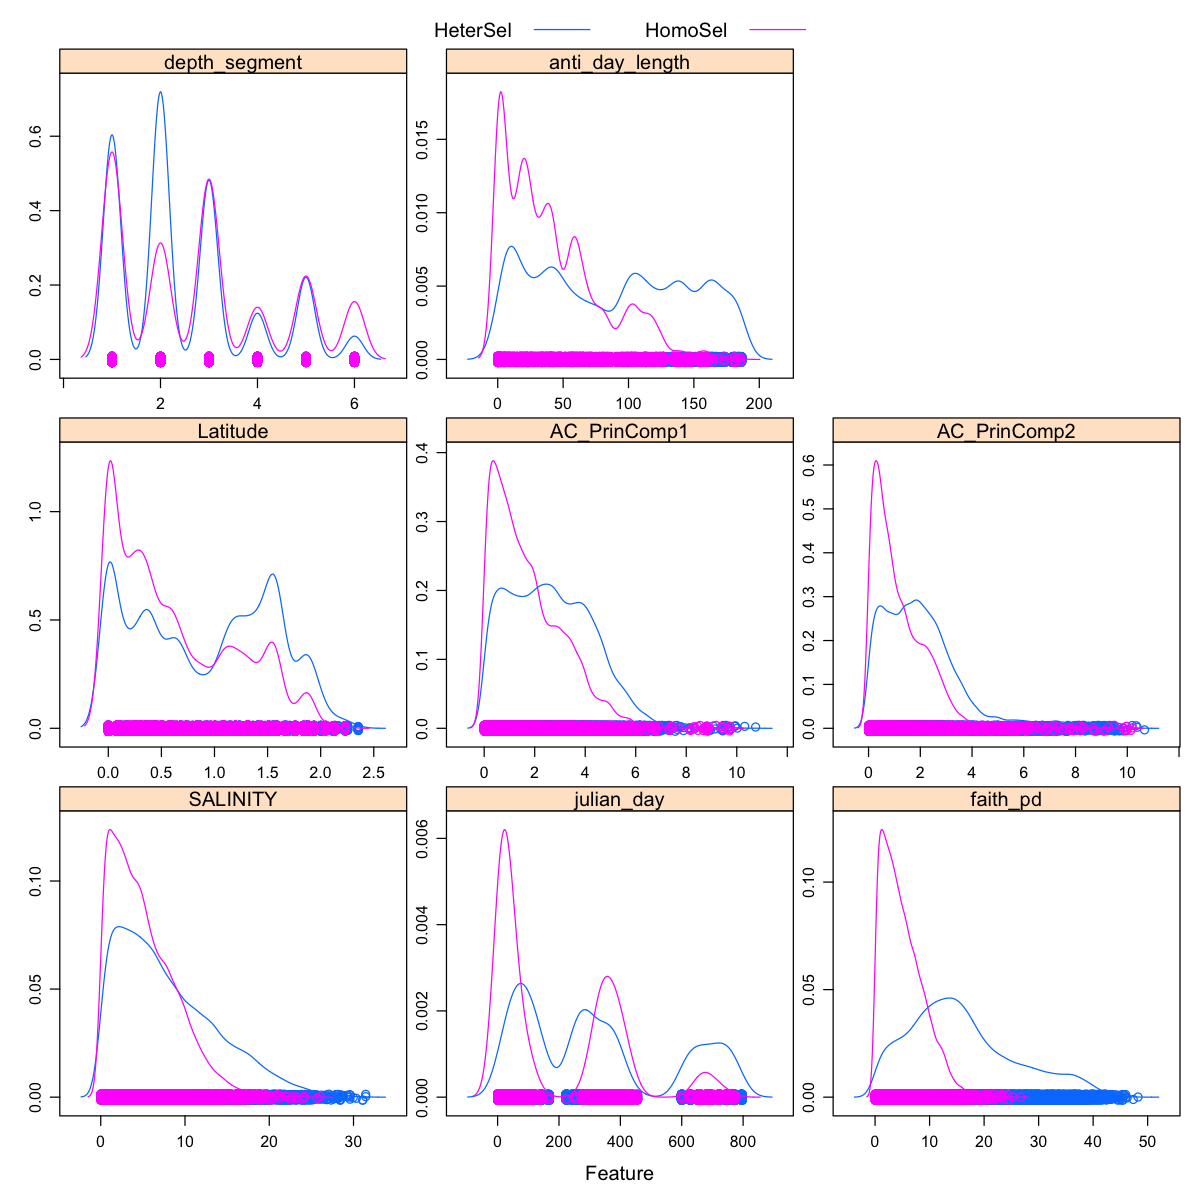

In [229]:
reg_df_sel = reg_df2[(as.character(reg_df2$Outcome) %in% c("HeterSel", 'HomoSel')), ]
reg_df_sel$Outcome <- factor(reg_df_sel$Outcome, levels=unique(reg_df_sel$Outcome))
reg_df_sel$anti_day_length <- (reg_df_sel$anti_day_length*193)/2
reg_df_selc = reg_df_sel
reg_df_selc$depth_segment = as.numeric(as.integer(reg_df_selc$depth_segment))
reg_df_selc$julian_day = as.numeric(reg_df_selc$julian_day)

library(corrplot)

options(repr.plot.width=5, repr.plot.height=5)
corrplot(cor(reg_df_selc[,selected_preds]), method="circle", addCoef.col='black', number.cex=0.5)

library(caret)
x <- reg_df_selc[,2:9]
y <- reg_df_selc[,1]
options(repr.plot.width=10, repr.plot.height=10)
scales <- list(x=list(relation="free"), y=list(relation="free"))
featurePlot(x=x, y=y, plot="density", scales=scales, auto.key = list(columns = 2))
levels(reg_df_sel$depth_segment)

In [236]:
psuedoR2 <-function(mod, mod0, N) {
    LLf   <- logLik(mod)
    LL0   <- logLik(mod0)
    pR2 = as.vector((1 - exp((2/N) * (LL0 - LLf))) / (1 - exp(LL0)^(2/N)))
    return(pR2)
}

split <- createDataPartition(y = reg_df_sel$Outcome, p = 0.75)
new_train <- reg_df_sel[split$Resample1,] 
new_test <- reg_df_sel[!(rownames(reg_df_sel) %in% rownames(new_train)), ]

log_model <- glm(Outcome~., data=new_train, family = binomial(link="logit"))
log_predict <- predict(log_model, newdata = new_test, type = "response")
log_predict <- ifelse(log_predict > 0.5, levels(reg_df_sel$Outcome)[2], levels(reg_df_sel$Outcome)[1])
log_cm = confusionMatrix(table(log_predict, new_test$Outcome))

selected_preds2 = c('faith_pd', 'Latitude', 'anti_day_length')

reg_df_sel2 = reg_df_sel[,c('Outcome', selected_preds2)]
accuracies = list('full' = log_cm$overall['Accuracy'])

for (a_col in selected_preds2){
    # drop a col
    reg_df2short = reg_df_sel2[,!(colnames(reg_df_sel2) == a_col)]
    # resplit
    new_train_s <- reg_df2short[split$Resample1,] 
    new_test_s <- reg_df2short[!(rownames(reg_df2short) %in% rownames(new_train_s)), ]
    # fit 
    log_model_s <- glm(Outcome~., data=new_train_s, family = binomial(link="logit"))
    log_predict_s <- predict(log_model_s, newdata = new_test_s, type = "response")
    log_predict_s <- ifelse(log_predict_s > 0.5, levels(reg_df_sel2$Outcome)[2], levels(reg_df_sel2$Outcome)[1])
    accuracies[[a_col]] = confusionMatrix(table(log_predict_s, new_test_s$Outcome))$overall['Accuracy'] - accuracies[['full']]
}
base::sort(unlist(accuracies))


faith_pd.Accuracy anti_day_length.Accuracy        Latitude.Accuracy 
             -0.16468200              -0.06752368              -0.04546685 
           full.Accuracy 
              0.86860622

In [239]:
summary(reg_df_sel[,c('faith_pd', 'anti_day_length', 'Latitude')])
levels(reg_df_sel$Outcome)
log_model_final <- glm(Outcome~faith_pd + anti_day_length + Latitude, data=reg_df_sel, family = binomial(link="logit"))
summary(log_model_final)
exp(cbind(OR = coef(log_model_final), confint(log_model_final)))

    faith_pd        anti_day_length     Latitude     
 Min.   : 0.00039   Min.   :  0.00   Min.   :0.0000  
 1st Qu.: 3.41728   1st Qu.: 18.34   1st Qu.:0.1967  
 Median : 7.83031   Median : 46.98   Median :0.6144  
 Mean   :10.40938   Mean   : 63.89   Mean   :0.7622  
 3rd Qu.:14.59041   3rd Qu.:104.67   3rd Qu.:1.3139  
 Max.   :48.23642   Max.   :186.84   Max.   :2.3530  

[1] "HeterSel" "HomoSel"


Call:
glm(formula = Outcome ~ faith_pd + anti_day_length + Latitude, 
    family = binomial(link = "logit"), data = reg_df_sel)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9850  -0.4359   0.1900   0.5583   3.1469  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      4.5096231  0.0534876   84.31   <2e-16 ***
faith_pd        -0.2600726  0.0035908  -72.43   <2e-16 ***
anti_day_length -0.0187653  0.0003775  -49.71   <2e-16 ***
Latitude        -1.2179703  0.0291088  -41.84   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 40969  on 29562  degrees of freedom
Residual deviance: 21363  on 29559  degrees of freedom
AIC: 21371

Number of Fisher Scoring iterations: 6


Waiting for profiling to be done...


,OR,2.5 %,97.5 %
(Intercept),90.8875532,81.9047435,101.0114995
faith_pd,0.7709956,0.7655469,0.7763988
anti_day_length,0.9814096,0.9806807,0.9821330
Latitude,0.2958300,0.2793717,0.3131407


faith_pd anti_day_length        Latitude 
       7.830313       46.981454        0.614440

predictor,variable,fit_resp,right_upr,right_lwr
<dbl>,<fct>,<dbl>,<dbl>,<dbl>
0.1273679,faith_pd,0.9451378,0.9487333,0.9413057
0.2500800,faith_pd,0.9434593,0.9471213,0.9395598
0.3877072,faith_pd,0.9415193,0.9452567,0.9375437
0.5232921,faith_pd,0.9395473,0.9433595,0.9354960
0.6536682,faith_pd,0.9375925,0.9414773,0.9334679
0.7906396,faith_pd,0.9354753,0.9394371,0.9312734


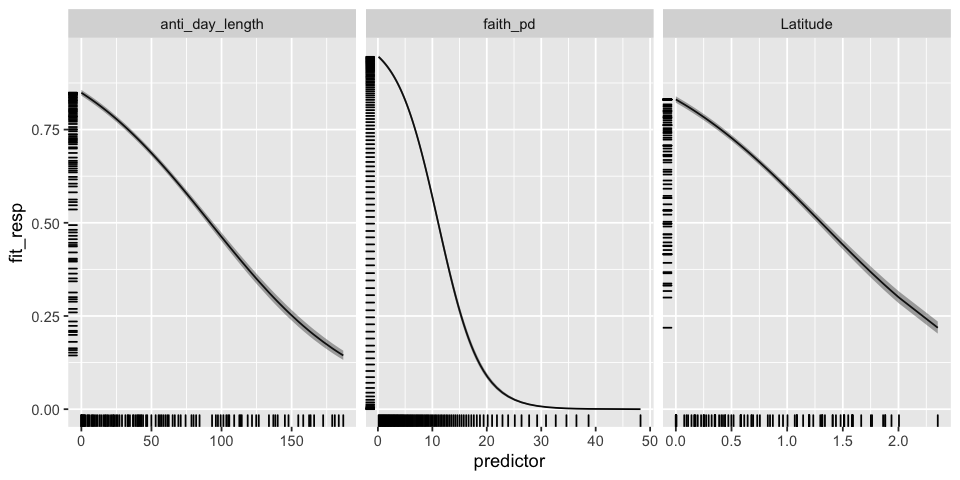

In [283]:
mean_row = apply(reg_df_sel[,c('faith_pd', 'anti_day_length', 'Latitude')], 2, median)
mean_row
mean_mat = matrix(1, nrow=300,ncol=1) %*% matrix(mean_row, nrow=1, ncol=3)

hundred_pts <- function(x) {return(quantile(x, (1:100)/100))}
pct_ranges = apply(reg_df_sel[,c('faith_pd', 'anti_day_length', 'Latitude')], 2, hundred_pts)
colnames(mean_mat) <- colnames(pct_ranges)
mean_df = as.data.frame(mean_mat)
mean_df[c(1:100), 'faith_pd'] = pct_ranges[,'faith_pd']
mean_df[c(101:200), 'anti_day_length'] = pct_ranges[,'anti_day_length']
mean_df[c(201:300), 'Latitude'] = pct_ranges[,'Latitude']

ilink <- family(log_model_final)$linkinv
model_output <- predict(log_model_final, newdata=mean_df, se.fit = TRUE)[1:2]
model_output2 <- data.frame('fit_resp' = ilink(model_output$fit), 
                            'right_upr' = ilink(model_output$fit + (2*model_output$se.fit)),
                            'right_lwr' = ilink(model_output$fit - (2*model_output$se.fit)))

predictor_range = c(pct_ranges[,'faith_pd'], 
                    pct_ranges[,'anti_day_length'], 
                    pct_ranges[,'Latitude'])

var_grps = c(rep('faith_pd', 100), rep('anti_day_length', 100), rep('Latitude', 100))
mopdf = data.frame('predictor'=predictor_range, 'variable'=var_grps)
mopdf = cbind.data.frame(mopdf, model_output2)


#ggplot(mod_out_plotdf, aes(x=predictor, y=response, group=variable)) + 

#geom_ribbon(data=predframe,aes(ymin=lwr,ymax=upr),alpha=0.3))
head(mopdf)
plt <- ggplot(data = mopdf, aes(x = predictor, y = fit_resp)) + geom_line() +
       geom_rug(aes(x=predictor)) + 
       geom_ribbon(data = mopdf, aes(ymin = right_lwr, ymax = right_upr), alpha = 0.4) + 
       facet_grid(. ~ variable,scales='free')
plt

In [181]:
#ftest <- multinom(Outcome ~ faith_pd + anti_day_length + depth_segment + Latitude + AC_PrinComp1, data = reg_df2)
psuedoR2(ftest, test0, nrow(reg_df2))
summary(ftest)


[1] 0.4977847

Call:
multinom(formula = Outcome ~ faith_pd + anti_day_length + depth_segment + 
    Latitude + AC_PrinComp1, data = reg_df2)

Coefficients:
        (Intercept)   faith_pd anti_day_length depth_segmentBottom.Middle
Undom      1.395319 -0.1716010      -1.5233425                 -0.2138207
LtdDisp    2.803827 -0.1689330      -0.2989602                 -0.3371070
HomoSel    5.759279 -0.2783968      -2.2223687                 -0.6902531
        depth_segmentBottom.Top depth_segmentMiddle.Middle
Undom                 0.9337051                 -0.5117742
LtdDisp               0.6679776                 -1.0324750
HomoSel               1.1069672                 -0.2456406
        depth_segmentMiddle.Top depth_segmentTop.Top   Latitude AC_PrinComp1
Undom                 1.7584797            1.7173229 -1.0840113   -0.2562194
LtdDisp               0.5348259            0.4852796 -0.5162324   -0.2464660
HomoSel               1.6772880            1.7893660 -1.5637708   -0.4082146

Std. Errors:
     

In [231]:
full_df2 = full_df[full_df$Outcome != 'HighDisp',]
dim(full_df2)

[1] 41899    19

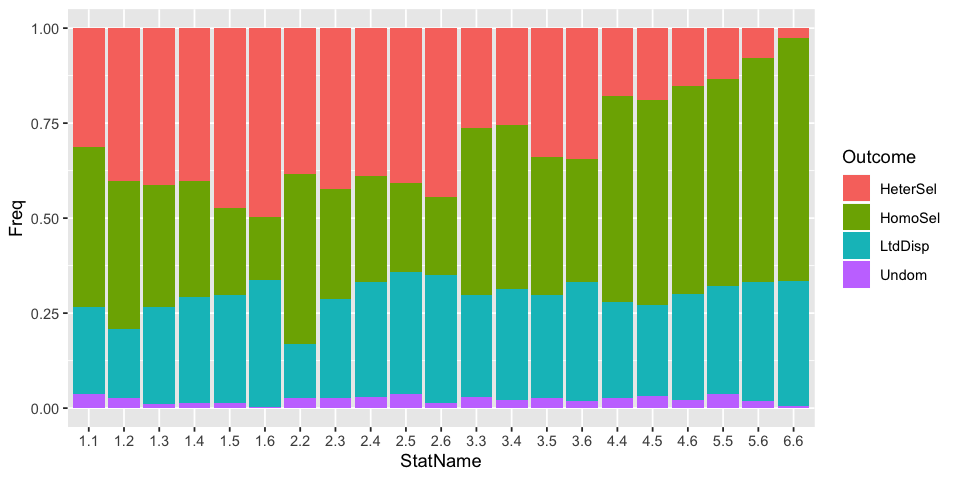

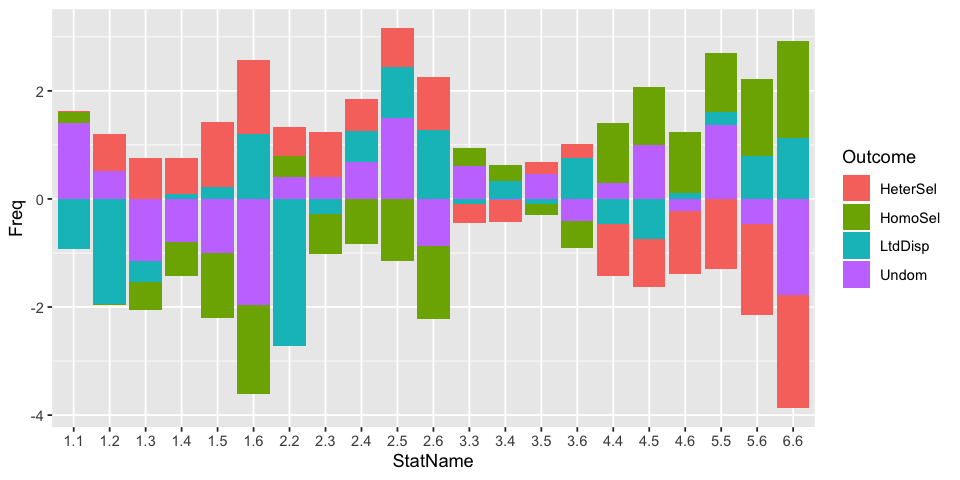

In [235]:
options(repr.plot.width=8, repr.plot.height=4)
stat_tally = table(full_df2[,c('StatName', 'Outcome')])
rel_st = stat_tally / rowSums(stat_tally)
scal_rel_st = as.data.frame(scale(rel_st))
unscal_rel_st = as.data.frame(rel_st)

library(ggplot2)

# Stacked + percent
ggplot(unscal_rel_st, aes(fill=Outcome, y=Freq, x=StatName)) + geom_bar(position="stack", stat="identity")
ggplot(scal_rel_st, aes(fill=Outcome, y=Freq, x=StatName)) + geom_bar(position="stack", stat="identity")

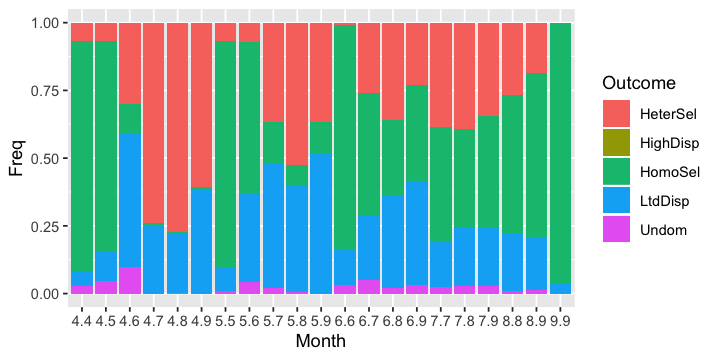

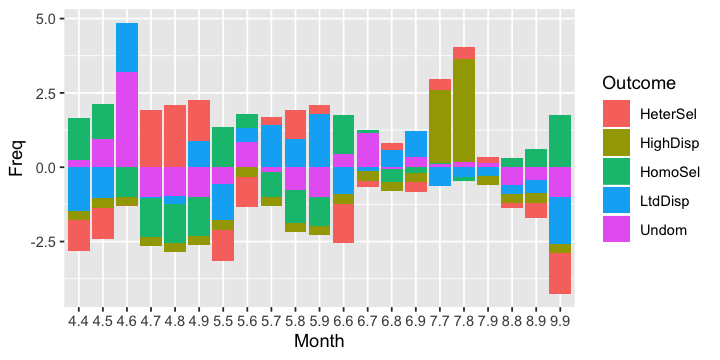

In [122]:
month_tally = table(full_df[,c('Month', 'Outcome')])
rel_mo = month_tally / rowSums(month_tally)
scal_rel_mo = as.data.frame(scale(rel_mo))
unscal_rel_mo = as.data.frame(rel_mo)

# Stacked + percent
ggplot(unscal_rel_mo, aes(fill=Outcome, y=Freq, x=Month)) + geom_bar(position="stack", stat="identity")
ggplot(scal_rel_mo, aes(fill=Outcome, y=Freq, x=Month)) + geom_bar(position="stack", stat="identity")


[1]  214 1011

In [ ]:
# A comparison of deviations between this an BNTI would reveal instances where one sample represents essentially a subgroup of another 
#nri_fn = "../otu_data/dispersal_selection_data/ses_mpd.RData"
#nri_df <- read.delim(nri_fn, row.names=1)